In [1]:
# nbeats_backtest_save.py  (Jupyter-friendly)
%matplotlib inline

import os, glob, math, random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------- CONFIG -----------------
DATA_FOLDER = r"C:\Users\sohan\Downloads\archive (1)"   # <<< update
OUTPUT_ROOT = "outputs_nbeats"
os.makedirs(OUTPUT_ROOT, exist_ok=True)

# Model / train settings
INPUT_SIZE = 30        # look-back window (days)
FORECAST_SIZE = 7      # horizon
N_BLOCKS = 3
HIDDEN_UNITS = 128
N_LAYERS_BLOCK = 4
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-3
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42

# ----------------- REPRODUCIBILITY -----------------
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# ----------------- UTILITIES -----------------
def rmse(a,b): return math.sqrt(mean_squared_error(a,b))
def mape(a,b):
    a = np.array(a); b = np.array(b)
    eps = 1e-9
    return np.mean(np.abs((a - b) / (np.abs(a) + eps))) * 100
def smape(a,b):
    a = np.array(a); b = np.array(b)
    eps = 1e-9
    return 100.0 * np.mean(2.0 * np.abs(b - a) / (np.abs(a) + np.abs(b) + eps))
def directional_accuracy(a,b):
    a = np.array(a); b = np.array(b)
    # compare sign of day-over-day changes (or simple delta between t and t+1)
    return np.mean(np.sign(b[1:] - b[:-1]) == np.sign(a[1:] - a[:-1]))

# ----------------- N-BEATS blocks / model -----------------
class NBeatsBlock(nn.Module):
    def __init__(self, input_size, theta_size, hidden_units, n_layers):
        super().__init__()
        layers = []
        in_dim = input_size
        for _ in range(n_layers):
            layers.append(nn.Linear(in_dim, hidden_units))
            layers.append(nn.ReLU())
            in_dim = hidden_units
        self.stack = nn.Sequential(*layers)
        self.theta = nn.Linear(hidden_units, theta_size)  # theta_size = backcast + forecast
        self.backcast_len = input_size
        self.forecast_len = theta_size - input_size

    def forward(self, x):
        x = self.stack(x)
        theta = self.theta(x)
        backcast = theta[:, :self.backcast_len]
        forecast = theta[:, self.backcast_len:]
        return backcast, forecast

class NBeats(nn.Module):
    def __init__(self, input_size, forecast_size, n_blocks=3, hidden_units=128, n_layers=4):
        super().__init__()
        self.blocks = nn.ModuleList([
            NBeatsBlock(input_size=input_size,
                        theta_size=input_size + forecast_size,
                        hidden_units=hidden_units,
                        n_layers=n_layers)
            for _ in range(n_blocks)
        ])

    def forward(self, x):
        # x shape: (batch, input_size)
        residual = x
        forecast_sum = torch.zeros((x.size(0), self.blocks[0].forecast_len), device=x.device)
        for block in self.blocks:
            backcast, forecast = block(residual)
            residual = residual - backcast
            forecast_sum = forecast_sum + forecast
        return forecast_sum

# ----------------- Dataset -----------------
class TimeSeriesDataset(Dataset):
    def __init__(self, series, input_size, forecast_size):
        self.series = series.astype(np.float32)
        self.input_size = input_size
        self.forecast_size = forecast_size

    def __len__(self):
        return max(0, len(self.series) - self.input_size - self.forecast_size + 1)

    def __getitem__(self, idx):
        x = self.series[idx: idx + self.input_size]
        y = self.series[idx + self.input_size: idx + self.input_size + self.forecast_size]
        return torch.tensor(x), torch.tensor(y)

# ----------------- Train / Backtest functions -----------------
def train_model(model, train_loader, val_loader, epochs=50, lr=1e-3, device=DEVICE):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val = float("inf")
    best_state = None
    for epoch in range(1, epochs+1):
        model.train()
        train_loss = 0.0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            y_pred = model(xb)
            loss = criterion(y_pred, yb)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * xb.size(0)
        train_loss /= len(train_loader.dataset)

        # val
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                y_pred = model(xb)
                val_loss += criterion(y_pred, yb).item() * xb.size(0)
        val_loss /= len(val_loader.dataset)

        if val_loss < best_val - 1e-9:
            best_val = val_loss
            best_state = {k:v.cpu().clone() for k,v in model.state_dict().items()}
        print(f"Epoch {epoch}/{epochs}  train_loss={train_loss:.6f}  val_loss={val_loss:.6f}")

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

def sliding_backtest(model, series_scaled, input_size, forecast_size, scaler=None, device=DEVICE):
    model.eval()
    preds = []
    trues = []
    with torch.no_grad():
        for i in range(len(series_scaled) - input_size - forecast_size + 1):
            x = torch.tensor(series_scaled[i:i+input_size], dtype=torch.float32).unsqueeze(0).to(device)
            y_pred = model(x).cpu().numpy().flatten()
            y_true = series_scaled[i+input_size:i+input_size+forecast_size]
            preds.append(y_pred)
            trues.append(y_true)
    preds = np.array(preds)
    trues = np.array(trues)
    # inverse transform if scaler provided
    if scaler is not None:
        # preds shape (steps, forecast_size)
        preds = scaler.inverse_transform(preds)
        trues = scaler.inverse_transform(trues)
    return preds, trues

# ----------------- Plot helpers -----------------
def save_actual_vs_pred(series, preds, out_path, title):
    plt.figure(figsize=(12,4))
    # align t+1 predictions to last len(preds) positions
    start = len(series) - preds.shape[0]
    plt.plot(series, color='black', label='Actual')
    plt.plot(range(start, start+preds.shape[0]), preds[:,0], color='red', label='Predicted t+1')
    plt.title(title); plt.xlabel('Index'); plt.ylabel('Close'); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()

def save_residual_hist(actual, pred, out_path, title):
    res = (actual - pred).flatten()
    plt.figure(figsize=(6,4))
    sns.histplot(res, bins=40, kde=True)
    plt.title(title); plt.tight_layout(); plt.savefig(out_path, dpi=200); plt.close()

# ----------------- Main loop -----------------
all_metrics = []
csv_files = sorted(glob.glob(os.path.join(DATA_FOLDER, "*.csv")))
# skip healthcare if requested:
csv_files = [f for f in csv_files if "HEALTHCARE" not in os.path.basename(f).upper()]

for filepath in csv_files:
    try:
        sector = os.path.splitext(os.path.basename(filepath))[0]
        print(f"\n--- {sector} ---")
        out_dir = os.path.join(OUTPUT_ROOT, sector)
        os.makedirs(out_dir, exist_ok=True)

        df = pd.read_csv(filepath)
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.sort_values('Date').reset_index(drop=True)
        series = df['Close'].values.astype(float)

        # scaling (MinMax) for model stability
        scaler = MinMaxScaler()
        series_scaled = scaler.fit_transform(series.reshape(-1,1)).flatten()

        # train/val split 80/20 on scaled series
        train_size = int(0.8 * len(series_scaled))
        train_series = series_scaled[:train_size]
        val_series = series_scaled[train_size - INPUT_SIZE:]  # ensure enough input window for val

        train_dataset = TimeSeriesDataset(train_series, INPUT_SIZE, FORECAST_SIZE)
        val_dataset = TimeSeriesDataset(val_series, INPUT_SIZE, FORECAST_SIZE)

        # handle if series too short
        if len(train_dataset) == 0 or len(val_dataset) == 0:
            print(f"  Skipping {sector}: series too short.")
            continue

        train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

        # model
        model = NBeats(input_size=INPUT_SIZE, forecast_size=FORECAST_SIZE,
                       n_blocks=N_BLOCKS, hidden_units=HIDDEN_UNITS, n_layers=N_LAYERS_BLOCK)
        model = train_model(model, train_loader, val_loader, epochs=EPOCHS, lr=LR, device=DEVICE)

        # full sliding backtest over entire scaled series
        preds, trues = sliding_backtest(model, series_scaled, INPUT_SIZE, FORECAST_SIZE, scaler=scaler, device=DEVICE)

        if preds.size == 0:
            print(f"  No predictions for {sector}.")
            continue

        # evaluate horizon t+1 (first column)
        y_pred_1 = preds[:, 0]
        y_true_1 = trues[:, 0]

        mae1 = mean_absolute_error(y_true_1, y_pred_1)
        rmse1 = rmse(y_true_1, y_pred_1)
        mape1 = mape(y_true_1, y_pred_1)
        smape1 = smape(y_true_1, y_pred_1)
        r2_1 = r2_score(y_true_1, y_pred_1)
        dir_acc = directional_accuracy(y_true_1, y_pred_1)

        metrics = {
            "sector": sector,
            "MAE_t+1": float(mae1),
            "RMSE_t+1": float(rmse1),
            "MAPE_t+1": float(mape1),
            "SMAPE_t+1": float(smape1),
            "R2_t+1": float(r2_1),
            "DirectionalAcc": float(dir_acc),
            "n_backtest_steps": int(preds.shape[0])
        }
        all_metrics.append(metrics)

        # save per-sector CSVs
        pd.DataFrame(preds).to_csv(os.path.join(out_dir, "preds_all_steps.csv"), index=False)
        pd.DataFrame(trues).to_csv(os.path.join(out_dir, "trues_all_steps.csv"), index=False)
        pd.DataFrame([metrics]).to_csv(os.path.join(out_dir, "metrics_t+1.csv"), index=False)

        # save visualizations
        save_actual_vs_pred(series, preds, os.path.join(out_dir, "actual_vs_pred_t+1.png"),
                            title=f"{sector} — Actual vs Pred (t+1)")
        save_residual_hist(y_true_1, y_pred_1, os.path.join(out_dir, "residual_hist_t+1.png"),
                           title=f"{sector} — Residuals (t+1)")

        # save model checkpoint
        torch.save(model.state_dict(), os.path.join(out_dir, "model_checkpoint.pth"))

        print(f"  Saved outputs -> {out_dir}")

    except Exception as e:
        print(f" ERROR {filepath}: {e}")
        continue

# master CSV
if len(all_metrics) > 0:
    master_df = pd.DataFrame(all_metrics)
    master_df.to_csv(os.path.join(OUTPUT_ROOT, "all_metrics_nbeats.csv"), index=False)
    print(f"\nMaster metrics saved to {os.path.join(OUTPUT_ROOT, 'all_metrics_nbeats.csv')}")
else:
    print("No metrics collected.")



--- NIFTY 50_cleaned ---
Epoch 1/50  train_loss=0.003870  val_loss=0.000713
Epoch 2/50  train_loss=0.000210  val_loss=0.000520
Epoch 3/50  train_loss=0.000148  val_loss=0.000702
Epoch 4/50  train_loss=0.000115  val_loss=0.000345
Epoch 5/50  train_loss=0.000122  val_loss=0.000375
Epoch 6/50  train_loss=0.000109  val_loss=0.000349
Epoch 7/50  train_loss=0.000109  val_loss=0.000404
Epoch 8/50  train_loss=0.000123  val_loss=0.001992
Epoch 9/50  train_loss=0.000128  val_loss=0.001093
Epoch 10/50  train_loss=0.000118  val_loss=0.000354
Epoch 11/50  train_loss=0.000103  val_loss=0.000383
Epoch 12/50  train_loss=0.000095  val_loss=0.000431
Epoch 13/50  train_loss=0.000117  val_loss=0.000365
Epoch 14/50  train_loss=0.000104  val_loss=0.000346
Epoch 15/50  train_loss=0.000090  val_loss=0.000421
Epoch 16/50  train_loss=0.000094  val_loss=0.000323
Epoch 17/50  train_loss=0.000096  val_loss=0.000403
Epoch 18/50  train_loss=0.000111  val_loss=0.000289
Epoch 19/50  train_loss=0.000090  val_loss=0.00

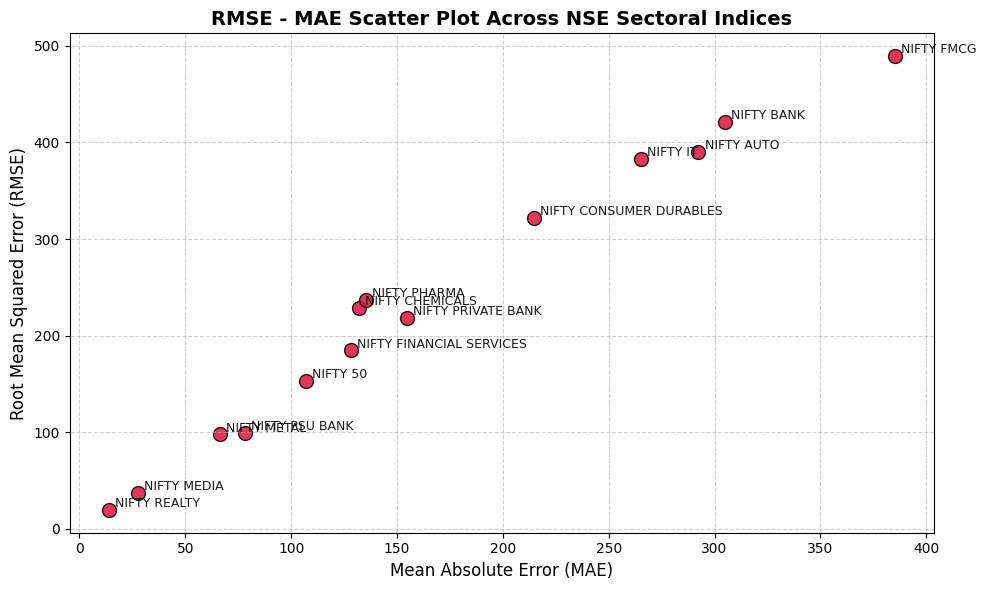

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
data = {
    "Sector": [
        "NIFTY 50", "NIFTY AUTO", "NIFTY BANK", "NIFTY CHEMICALS",
        "NIFTY CONSUMER DURABLES", "NIFTY FINANCIAL SERVICES", "NIFTY FMCG",
        "NIFTY IT", "NIFTY MEDIA", "NIFTY METAL", "NIFTY PHARMA",
        "NIFTY PRIVATE BANK", "NIFTY PSU BANK", "NIFTY REALTY"
    ],
    "MAE": [
        106.95, 292.34, 304.99, 132.01, 214.76, 128.21,
        385.05, 265.17, 27.59, 66.39, 135.26, 154.62, 78.13, 13.94
    ],
    "RMSE": [
        153.37, 390.32, 421.22, 228.66, 322.23, 184.68,
        489.31, 383.19, 37.69, 97.81, 236.66, 218.34, 99.56, 19.60
    ]
}

df = pd.DataFrame(data)

# Create RMSE–MAE Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(df["MAE"], df["RMSE"], s=100, color="crimson", alpha=0.85, edgecolor="black")

# Annotate sector names
for i, txt in enumerate(df["Sector"]):
    plt.annotate(txt, (df["MAE"][i] + 3, df["RMSE"][i] + 3), fontsize=9, alpha=0.9)

plt.title("RMSE - MAE Scatter Plot Across NSE Sectoral Indices", fontsize=14, fontweight="bold")
plt.xlabel("Mean Absolute Error (MAE)", fontsize=12)
plt.ylabel("Root Mean Squared Error (RMSE)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()
